In [1]:
import torch
from torch import nn
from torch.nn import functional as F

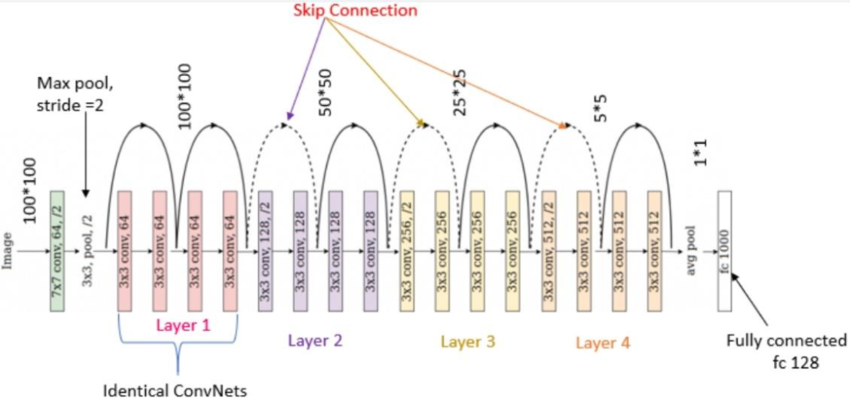

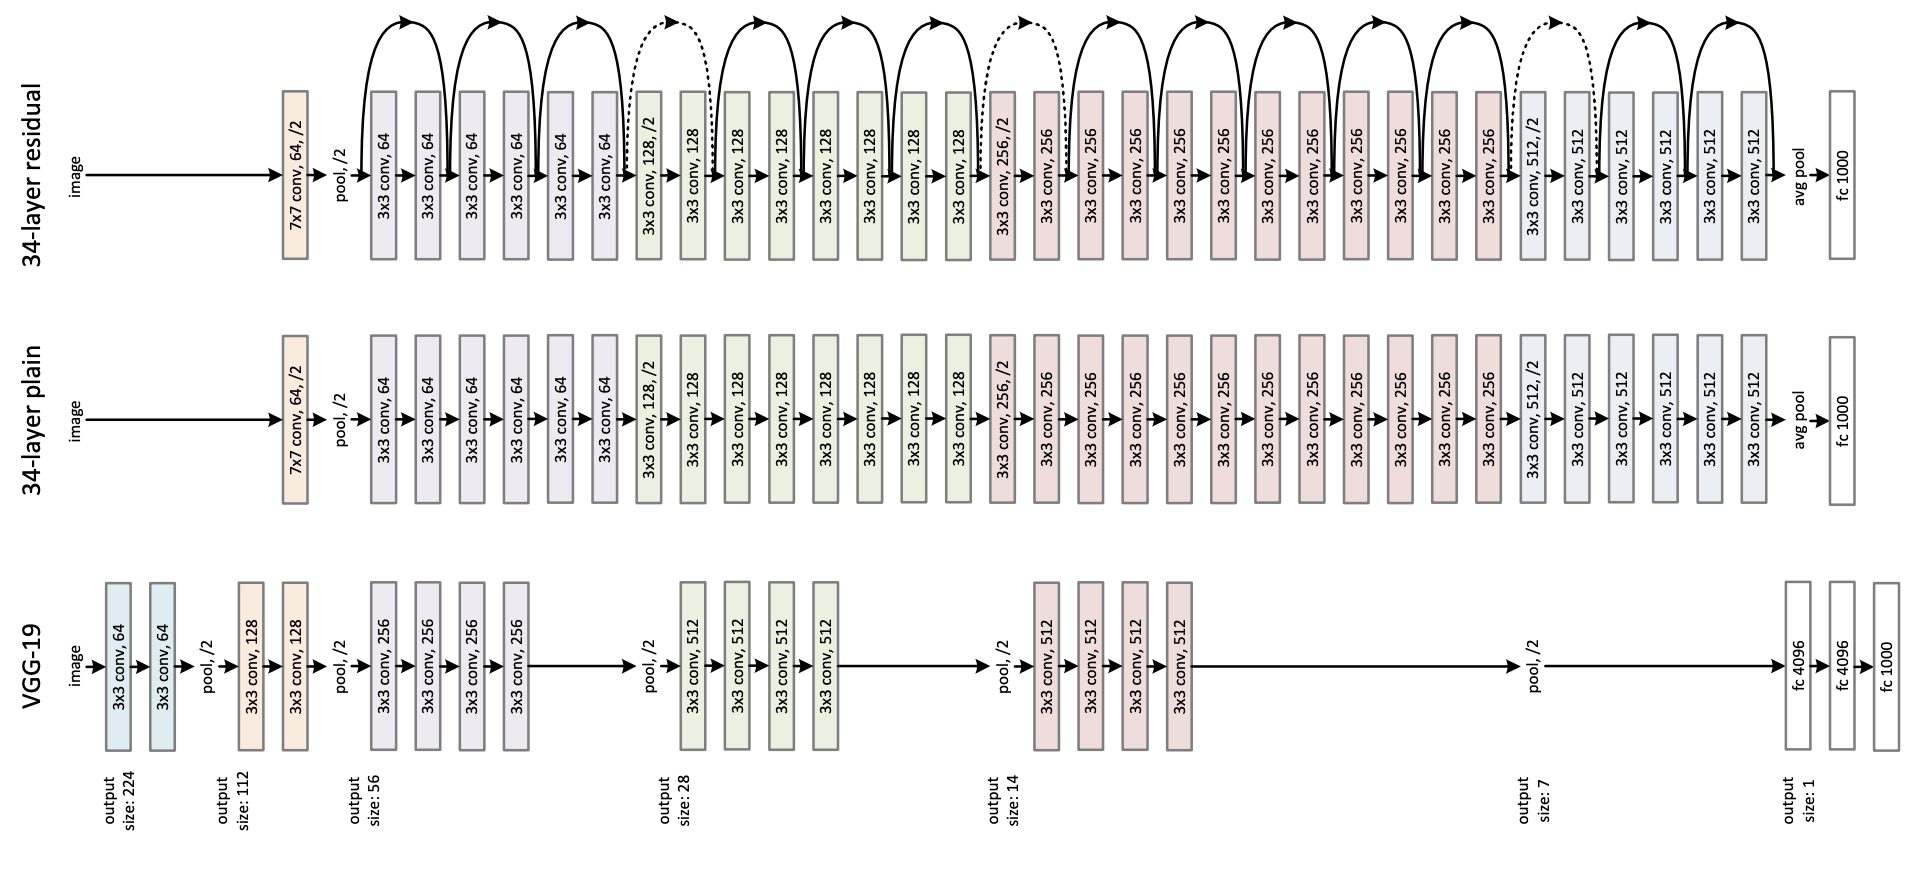

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(x)
        
        out += identity # residual
        out = self.relu(out)
        
        return out

def make_block(in_channels, out_channels, blocks, stride=1):
    downsample = None
    if stride != 1 or in_channels != out_channels:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
        )
    
    layers = []
    layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
    for _ in range(1, blocks):
        layers.append(ResidualBlock(out_channels, out_channels))
    
    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, block_out, block_depth, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = block_out[0]
        
        self.conv = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.layers = nn.ModuleList([make_block(in_channels, out_channels, blocks=depth, stride=2 if i > 0 else 1) 
                 for i, (in_channels, out_channels, depth) in enumerate(zip(block_out[:-1], block_out[1:], block_depth))])
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(block_out[-1], num_classes)
    
    def forward(self, x):
        x = self.conv(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

class ResNet18(ResNet):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__(
            block_out=[64, 64, 128, 256, 512],
            block_depth=[2, 2, 2, 2],
            num_classes=num_classes
        )

class ResNet34(ResNet):
    def __init__(self, num_classes=1000):
        super(ResNet34, self).__init__(
            block_out=[64, 64, 128, 256, 512],
            block_depth=[3, 4, 6, 3],
            num_classes=num_classes
        )

def test_resnet(model):
    x = torch.randn(4, 3, 224, 224)
    out = model(x)
    print("Input Shape:", x.shape)
    print("ResNet Output Shape:", out.shape)
    num_layers = sum(1 for _ in model.modules() if (isinstance(_, nn.Conv2d) or isinstance(_, nn.Linear)))
    print("ResNet Number of Layers:", num_layers)
    num_downsample = sum(1 for _ in model.modules() if isinstance(_, nn.Sequential) and 'downsample' in str(_))
    print("ResNet Number of Downsample:", num_downsample)
    print("ResNet Number of Layers except downsample:", num_layers - num_downsample)


In [3]:
test_resnet(ResNet18())

Input Shape: torch.Size([4, 3, 224, 224])
ResNet Output Shape: torch.Size([4, 1000])
ResNet Number of Layers: 21
ResNet Number of Downsample: 3
ResNet Number of Layers except downsample: 18


In [4]:
test_resnet(ResNet34())

Input Shape: torch.Size([4, 3, 224, 224])
ResNet Output Shape: torch.Size([4, 1000])
ResNet Number of Layers: 37
ResNet Number of Downsample: 3
ResNet Number of Layers except downsample: 34


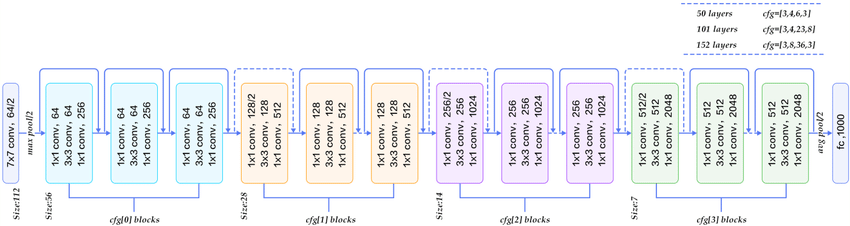

In [5]:
class ResidualBlock(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, kernel_size=1, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(
            out_channels, out_channels * self.expansion, kernel_size=1, stride=1, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity  # Residual connection
        out = self.relu(out)

        return out

def make_block(in_channels, out_channels, blocks, stride=1):
    downsample = None
    expansion = ResidualBlock.expansion

    if stride != 1 or in_channels != out_channels * expansion:
        downsample = nn.Sequential(
            nn.Conv2d(in_channels, out_channels * expansion, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels * expansion),
        )

    layers = []
    layers.append(ResidualBlock(in_channels, out_channels, stride, downsample))
    for _ in range(1, blocks):
        layers.append(ResidualBlock(out_channels * expansion, out_channels))

    return nn.Sequential(*layers)

class ResNet(nn.Module):
    def __init__(self, block_out, block_depth, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = block_out[0]

        self.conv = nn.Sequential(
            nn.Conv2d(3, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layers = nn.ModuleList()
        in_channels = self.in_channels
        for i, (out_channels, depth) in enumerate(zip(block_out[1:], block_depth)):
            self.layers.append(make_block(in_channels, out_channels, depth, stride=2 if i > 0 else 1))
            in_channels = out_channels * ResidualBlock.expansion

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(block_out[-1] * ResidualBlock.expansion, num_classes)

    def forward(self, x):
        x = self.conv(x)
        
        for layer in self.layers:
            x = layer(x)
        
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        
        return x

class ResNet50(ResNet):
    def __init__(self, num_classes=1000):
        super(ResNet50, self).__init__(
            block_out=[64, 64, 128, 256, 512],
            block_depth=[3, 4, 6, 3],
            num_classes=num_classes
        )

class ResNet101(ResNet):
    def __init__(self, num_classes=1000):
        super(ResNet101, self).__init__(
            block_out=[64, 64, 128, 256, 512],
            block_depth=[3, 4, 23, 3],
            num_classes=num_classes
        )

class ResNet152(ResNet):
    def __init__(self, num_classes=1000):
        super(ResNet152, self).__init__(
            block_out=[64, 64, 128, 256, 512],
            block_depth=[3, 8, 36, 3],
            num_classes=num_classes
        )


In [6]:
test_resnet(ResNet50())


Input Shape: torch.Size([4, 3, 224, 224])
ResNet Output Shape: torch.Size([4, 1000])
ResNet Number of Layers: 54
ResNet Number of Downsample: 4
ResNet Number of Layers except downsample: 50


In [7]:
test_resnet(ResNet101())


Input Shape: torch.Size([4, 3, 224, 224])
ResNet Output Shape: torch.Size([4, 1000])
ResNet Number of Layers: 105
ResNet Number of Downsample: 4
ResNet Number of Layers except downsample: 101


In [8]:
test_resnet(ResNet152())


Input Shape: torch.Size([4, 3, 224, 224])
ResNet Output Shape: torch.Size([4, 1000])
ResNet Number of Layers: 156
ResNet Number of Downsample: 4
ResNet Number of Layers except downsample: 152
